# Simple Transfer Learning Example in Tensorflow

This notebook goes over a simple classification problem using tensorflow. I used is a pretrained VGG16 model, and data in the Cifar dataset.



In [28]:
# some helpful packages
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
#import keras

%matplotlib inline

Let's start by loading the CIFAR dataset. We will load the CIFAR-10 dataset found in keras that contains common images with 10 classes. These images are small(32 by 32 pixels), and are 3-channel RGB images.





In [29]:
# load the training and testing data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
img_cols, img_rows, img_chs = x_train.shape[1:]
num_classes = 10

x_test, x_val = np.split(x_test, 2)
y_test, y_val = np.split(y_test, 2)

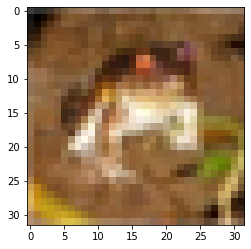

In [30]:
# display one of the images with matplotlib
plt.imshow(x_train[0,:,:])
plt.show()

We need to do some preprocessing before we start training. First we want to **scale** the images from [0,1]. This is not the only way to normalize an image.
Generally this helps the model converge faster but it isn't strictly nessecary. We also converted the labels (y_train, and y_test) into one-hot encoded data.

We also split the testing data, into two. This is so we get **training, testing and validation data**. It is important to keep the data separate so we are not training on the testing data, causing overfitting, and making the model seem like it's preforming better than it is.

The **training** data will be used to adjust the weights in the model. The **testing** data will be used to assess how well the model is preforming. This information can be used to adjust hyperparameters like learning rate, number of epoochs, batch size and more. When we are finally done with our model, we then use the **validation** data to get a final assessement of how well the model preforms. 


*Please note that some references switch the meanings behind testing and validation data. It is important that we keep it clear what data is what.*


In [31]:
# normalize the images from [0,1]
x_train = x_train / 255
x_test = x_test / 255
x_val = x_val / 255

# convert convert the data into hot-encoded data
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

# Building a Model 

We will be using one of Keras' pretrained models. This will be **VGG16**. Keras has many pretrained models avalible. You can find documentation here:https://keras.io/api/applications/. You can also find Keras' library of pretrained models.

First lets load the model. In this example we are loading VGG16, a convolutional neural network proposed by K. Simonyan and A. Zisserman. If you would like more information you can read about it in their paper here: https://arxiv.org/abs/1409.1556

We will load VGG16 with the following line. Here we can specify the shape of the input image, the training weights, and if the last few layers of the model will or will not be included. 

In this situation, we do not need to resize our images. We can load the pretrained model, and adjust the input layer. In some models, we can't resize the input layer, and must resize the images instead.


In [32]:
# we will load VGG16 with the following line. Here we can specify the shape of the input image, the training weights, and if the last few layers of the model will or willnot be included
base_model =  keras.applications.vgg16.VGG16(input_shape=[img_cols, img_rows, img_chs], include_top = False, pooling="avg", weights = 'imagenet')

We have loaded the model. Now let's take a closer look at the layers. If we want more information on a model we can use the method '.summary()' to print a summary.

In [33]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     


Now we need to add in the output layers. If we used the argument 'include_top = False' above, then the model would output 1000 parameters. We would want this if we had 1000 classications. But we have 10 classifications.

The last layer is a 'global_average_pooling2d' layer. We will add a fully connected layer, a drop out layer, and a dense layer that outlines how many classes we have.

At this point, we could also **freeze** a few layers. What this means is the weights and biases found in the model will not change while the model is training. This can speed up training time, since we are not adjusting as many weights and bias. Since we are using a pretrained model, we can assume that a few of the layers get very important features from the images.


In [34]:
num_freeze = 10
num_outputs = num_classes

# we can freeze a few layers. 
for layer in base_model.layers[:num_freeze]:
  layer.trainable = False

# add output layers
x = keras.layers.Dense(128, activation='relu')(base_model.output)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

# we need to ensure there are 10 nodes in this layer because we have 10 classes.
x = keras.layers.Dense(num_outputs, activation='sigmoid')(x)

model = keras.models.Model(inputs = base_model.input, outputs = x)    


Now we compile the model. Here we specify the **loss function, optimizer, learning rate and accuracy**. If we want a custom loss function, optimizer or add a different error metric, we can specify that here.

In [35]:
# compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])
              
# display a summary of the model              
display(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

None

# Training 

Now it's time to train the network. Use the 'fit' method in keras to train using the training data. Validate on the testing data. We can chose a batch size and number of epochs to our liking. 



In [36]:
# fit the model
history = model.fit(x_train, y_train,
          batch_size = 126,
          epochs = 10,
          verbose = 1,
          validation_data = (x_test, y_test))


Epoch 1/10
397/397 [==============================] - 10s 24ms/step - loss: 1.7505 - accuracy: 0.2717 - val_loss: 1.3512 - val_accuracy: 0.4328
Epoch 2/10
397/397 [==============================] - 9s 24ms/step - loss: 1.2571 - accuracy: 0.5093 - val_loss: 0.9962 - val_accuracy: 0.6054
Epoch 3/10
397/397 [==============================] - 9s 24ms/step - loss: 0.9945 - accuracy: 0.6317 - val_loss: 0.9141 - val_accuracy: 0.6762
Epoch 4/10
397/397 [==============================] - 9s 24ms/step - loss: 0.8411 - accuracy: 0.7137 - val_loss: 0.8180 - val_accuracy: 0.7424
Epoch 5/10
397/397 [==============================] - 9s 24ms/step - loss: 0.7250 - accuracy: 0.7624 - val_loss: 0.7529 - val_accuracy: 0.7614
Epoch 6/10
397/397 [==============================] - 9s 24ms/step - loss: 0.6596 - accuracy: 0.7853 - val_loss: 0.7666 - val_accuracy: 0.7648
Epoch 7/10
397/397 [==============================] - 9s 24ms/step - loss: 0.5961 - accuracy: 0.8065 - val_loss: 0.7747 - val_accuracy: 0.762

# Network Results

To assess the model we can look at it's training history. We can plot the accuracy, and loss function of both the training data and testing data. If the testing data seems to preform much worse than the training data, that is a sign the model is overfitting.


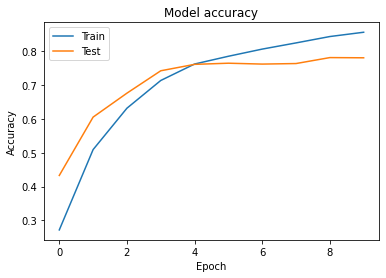

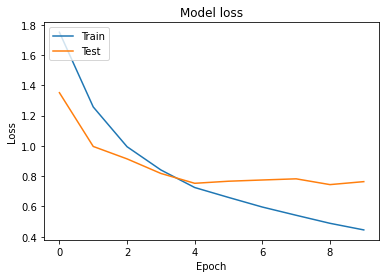

Test loss: 0.7638669013977051
Test accuracy: 0.7807999849319458


In [37]:

def plotHistory(history):
    ''' This function plots the training and validation loss and accuracy. This code has been writen in the Keras
    documentation which is very useful. It is located at:  https://keras.io/visualization/
    '''
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# show the training history in a plot.
plotHistory(history)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Error Metrics 
We can evaluate the model using the testing data. To do this we first have to convert the one-hot encoded variables back into integer labels.

We can then use one of sklearn's many error metric functions. In this case we will use classification_report to get the prevision, recall and f1 score for ever label. Depending on the problem we are trying to solve, we might use different error metrics like AUC, FNR, FPR, error rate and more. 

In [38]:
from sklearn.metrics import classification_report

# we will input x_test data in to model, and get the predicted labels
y_pred = model.predict(x_test, batch_size=128, verbose=1)

# convert one-encoded values to integer labels
y_pred_int = np.argmax(y_pred, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# print a confusion matrix
print(classification_report(y_test_int, y_pred_int))

40/40 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       488
           1       0.89      0.87      0.88       505
           2       0.84      0.63      0.72       512
           3       0.59      0.53      0.56       497
           4       0.70      0.81      0.75       507
           5       0.60      0.74      0.66       488
           6       0.83      0.85      0.84       491
           7       0.91      0.79      0.84       495
           8       0.85      0.93      0.89       504
           9       0.85      0.83      0.84       513

    accuracy                           0.78      5000
   macro avg       0.79      0.78      0.78      5000
weighted avg       0.79      0.78      0.78      5000

